# Введение в машинное обучени

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [4]:
sns.set_style("darkgrid") #у графиков будет красивая серая подложка

Также с этого дня ты начнешь работать с библиотекой `scikit-learn`, в которой как раз много удобных функций и методов для машинного обучения и предобработки данных. Но ее мы будем добавлять точечно по ходу процесса анализа данных для большей наглядности. 

## Демонстрационный датасет

Рассмотрим датасет вин. Есть вина, произведенные на трех разных виноградниках. Нужно научиться определять какое вино относится к какому винограднику. Нашу задачу сократим для удобства до двух виноградников и только двух признаков: процент алкоголя и уровень пролина (аминокислота, входящая в состав вин).

In [5]:
from sklearn.datasets import load_wine

In [6]:
data = load_wine()
wine_df = pd.DataFrame(data.data, columns=data.feature_names)
wine_df.insert(13, 'CLASS', data.target)
wine_two_classes = wine_df.loc[(wine_df.CLASS == 0) | (wine_df.CLASS == 1)]
wine_ready = wine_two_classes[['alcohol', 'proline', 'CLASS']]

In [7]:
wine_ready.head(2)

,alcohol,proline,CLASS
0,14.23,1065.0,0
1,13.20,1050.0,0


Визуализируем распределение вин по уровню алкоголя и пролина при помощи диаграммы рассеяния и расскрасим точки в соответствии с виноградниками.

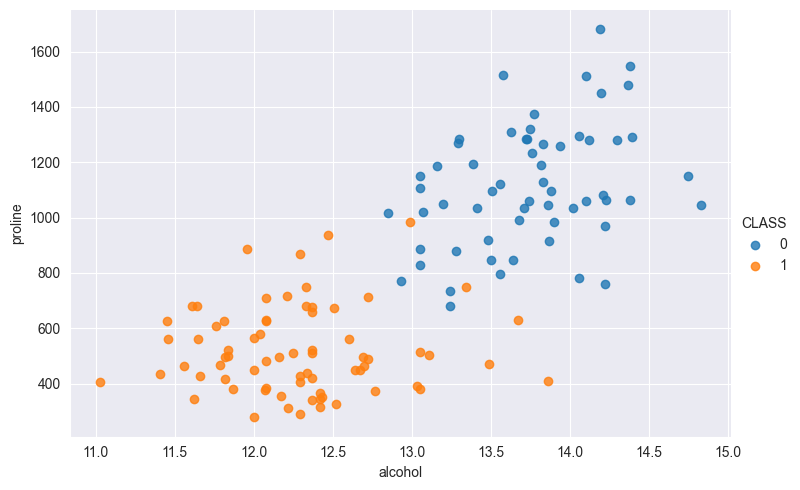

In [8]:
sns.lmplot(
    x="alcohol", y="proline", data=wine_ready, fit_reg=False, hue='CLASS', legend=True, height=5, aspect=1.5
);

Кажется, невооруженным взглядом видно, что виноградники производят отличающиеся группы вин. И можно придумать какое-то правило (или границу), по которой можно было провести отсечение: что вот всё, что тут, мы будем считать произведенным на первом винограднике, а всё, что там, мы будем считать – на втором винограднике.

In [9]:
from sklearn.linear_model import LogisticRegression

In [10]:
X = wine_ready[['alcohol', 'proline']]
y = wine_ready['CLASS']

In [11]:
clf = LogisticRegression(random_state=21).fit(X, y) #обучим модель

In [12]:
clf.coef_ #посмотрим на коэффициенты при получившейся регрессии

array([[-2.07000729, -0.01197466]])

Один коэффициент получился большим, а второй маленьким. Разница в 200 раз. Это может быть не очень хорошо. Проблема в том, что изначально наши признаки находились в разных шкалах по размеру. Лучше их привести в какую-то одну общую размерность.

In [13]:
from sklearn.preprocessing import StandardScaler

In [14]:
scaler = StandardScaler()
X2 = scaler.fit_transform(X) #сделаем стандартизацию наших признаков

In [15]:
X2[:5]

array([[ 1.452455  ,  0.782868  ],
       [ 0.28906609,  0.74015178],
       [ 0.24388594,  1.12459784],
       [ 1.61058554,  1.96468369],
       [ 0.33424624, -0.15688904]])

Как видно, признаки теперь у нас находятся примерно в одной какой-то шкале. Лог. регрессии будет теперь проще подобрать коэффициенты, которые при этом будут тоже примерно находится в одной размерности.

In [16]:
clf2 = LogisticRegression(random_state=21).fit(X2, y)

In [17]:
clf2.coef_

array([[-2.09192663, -2.4554651 ]])

Сейчас будет много кода для того, чтобы построить красивый график. Этот кусок кода тебе в самостоятельной части не понадобится, поэтому можно на нем сильно не заострять внимание.

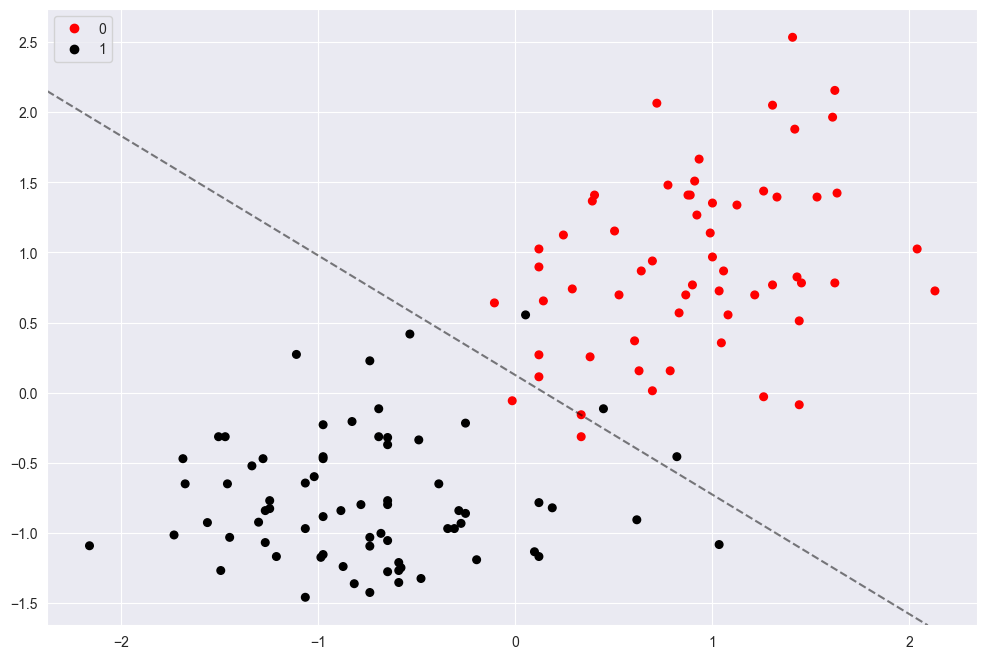

In [18]:
plt.figure(figsize=(12,8))
a = plt.scatter(X2[:, 0], X2[:, 1], c=y, s=30, cmap='flag')

# plot the decision function
ax = plt.gca()
xlim = ax.get_xlim()
ylim = ax.get_ylim()

# create grid to evaluate model
xx = np.linspace(xlim[0], xlim[1], 30)
yy = np.linspace(ylim[0], ylim[1], 30)
YY, XX = np.meshgrid(yy, xx)
xy = np.vstack([XX.ravel(), YY.ravel()]).T
Z = clf2.decision_function(xy).reshape(XX.shape)
# plot decision boundary and margins
ax.contour(XX, YY, Z, colors='k', levels=[0], alpha=0.5,
           linestyles=['--', '-', '--'])
plt.legend(handles=a.legend_elements()[0], labels=['0', '1'], loc='upper left');

Что сделала лог. регрессия? По сути в геометрическом смысле она предложила провести прямую линию, которая наилучшим образом отсекает точки двух классов. Всё, что ниже и левее этой линии считаем черными точками, а то, что правее и выше – красными. Да, правило неидеальное – местами есть ошибки: какие-то черные точки мы считаем красными, и наоборот. Но в общем и целом модель неплохо справилась с этим.

Давай попробуем померить качество модели в каком-то числовом виде, а не только взглядом на график. Есть метрика `accuracy`, которая показывает % случаев, в которых модель верно угадала класс, по отношению к общему количеству наблюдений.

In [19]:
clf2.score(X2, y) * 100

96.15384615384616

В 96% случаев модель справилась с предсказанием хорошо. Эта метрика может быть обманчивой, если классы несбалансированы. Например, у тебя и так 95% наблюдений – это один и тот же класс. Модель может просто все точки покрасить в один цвет сразу и получить высокий уровень качества, но на самом деле она справилась недостаточно хорошо. Про более сложные метрики поговорим потом. Пока достаточно и этой.